# Semantic network analysis - Wind Turbine Resistance 

In [10]:
import networkx as nx
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
from collections import Counter
#stopwords and lemmatizer
import nltk
nltk.download('stopwords')
import nltk
nltk.download('wordnet')

from nltk.corpus import stopwords

from nltk.stem import PorterStemmer, WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load dataset
path_2_data = '/content/drive/MyDrive/FCTurbine/preprocessed_tweets_with_language.csv'
df = pd.read_csv(path_2_data)

#only sample english language tweets
df = df[df['EnglishTweet'] == 1]
df = df[pd.notna(df['tweet_cleaned_no_rt'])].sample(5000)



In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,username,user_id,tweet,timestamp,tweet_id,tweet_cleaned,language_estimate,language_estimate_acc,retweet,tweet_cleaned_no_rt,author_language_estimate,author_language_estimate_acc,EnglishTweet
123296,123296,11247,Real_BWEA,1441418581,@PeaceOnEarth222 @aDissentient @clim8resistanc...,Thu Jul 11 15:47:44 +0000 2019,1149344529725698048,for every rspb supporter who switches to ecotr...,English,0.978804,False,for every rspb supporter who switches to ecotr...,English,0.961897,1
233333,233333,121284,ONWindResist,104994684,Greenhouse operator concerned about location o...,Wed Dec 11 21:29:06 +0000 2013,410883967827443712,greenhouse operator concerned about location o...,English,0.872109,False,greenhouse operator concerned about location o...,English,0.865791,1
220040,220040,107991,NWWFAG,311984377,"Germany, Onshore Wind Farm Subsidies Will Fall...",Tue Nov 12 20:13:13 +0000 2013,400355622979256320,germany onshore wind farm subsidies will fall ...,English,0.730212,False,germany onshore wind farm subsidies will fall ...,English,0.907965,1
126695,126695,14646,LWEAG,1323109351,Element power..we will decimate your property ...,Fri Nov 28 07:14:16 +0000 2014,538229369018519616,element powerwe will decimate your property va...,English,0.867583,False,element powerwe will decimate your property va...,English,0.952268,1
158452,158452,46403,smarysb,132312630,Responsibility and a sense of duty create grea...,Sat Aug 22 13:40:47 +0000 2020,1297166832273694976,responsibility and a sense of duty create grea...,English,0.822336,False,responsibility and a sense of duty create grea...,English,0.901309,1


# Preprocessing



In [5]:
#list for saving tokenised pre processed tweets
docs =[]

#lemmatise 
lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')

#loop through tweets of df
for s in df.tweet_cleaned:
  #remove url 
  s = re.sub(r'http://\S+|https://\S+','',s)
  #remove usernames
  s = re.sub('@[\w]+','', s)
  #remove digits
  s = re.sub('[0-9]', '', s)
  # lowercase
  s = s.lower() 
  #remove punctuation
  s = re.sub(r'[^\w\s]','',s)
  #tokenise
  s = s.split()
  #remove stopwords
  s = [item for item in s if item not in stop]
  #lemmatise - move up??? needs cleaning
  s = [lemmatizer.lemmatize(item) for item in s]
  docs.append(s)


# Semantic Network

In [6]:
# make a fully connected graph out of oc-occurring words
edge_list = []
for i in docs:
  sub = nx.complete_graph(i) 
  edge_list.extend(list(sub.edges))


In [7]:
# Build non-directed graph, with non weighted edges
word_graph = nx.Graph() 
word_graph.add_edges_from(edge_list) # add edges from edge_list, without weights

In [9]:
#print number of nodes and edges
word_graph.number_of_nodes(),word_graph.number_of_edges()

(9498, 186830)

In [ ]:
#visualise the super dense messy initial semantic network - 
plt.figure(figsize=(12,12)) 

nx.draw(word_graph, with_labels = True)

plt.show()

In [11]:
# Additional pre-processing: remove infrequent words (words used less than 50 times)
  
c = Counter()

#loop through sample, only save words that occur more than 50 times
for doc in docs:
  c.update(Counter(doc))
vocab = c.most_common(25000)
vocab = set([w for w,count in vocab if count>50])
# remove words
docs = [[w for w in doc if w in vocab] for doc in docs]

In [12]:
#print length of vocab (== number of nodes)
len(vocab) 

107

In [15]:
#trying out network with 107 nodes
vocab_qualified = list(vocab)

docs_q = [[w for w in doc if w in vocab_qualified] for doc in docs]

In [18]:
#make new graph (non directed non weighted) with new qualified vocabulary
edge_list_q = []
for i in docs_q: 
    sub = nx.complete_graph(i) 
    edge_list_q.extend(list(sub.edges)) 

word_graph_qualified = nx.Graph() 
word_graph_qualified.add_edges_from(edge_list_q) 
word_graph_qualified.number_of_nodes(),word_graph_qualified.number_of_edges()

(107, 3883)

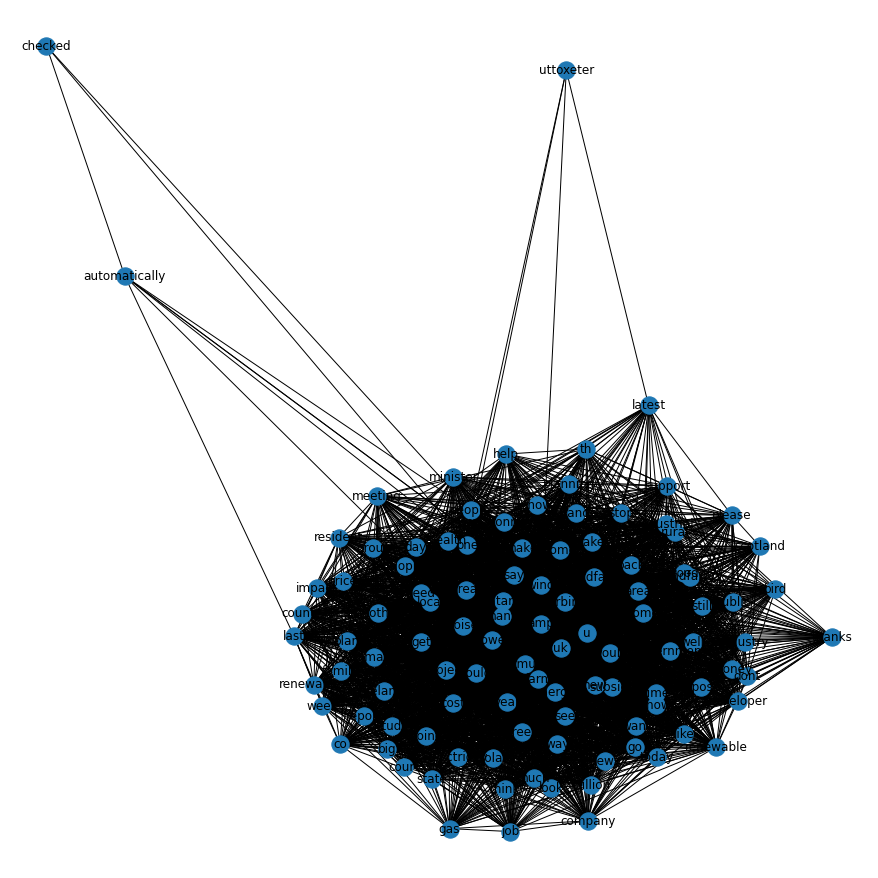

In [20]:
#visualise qualified network: still super dense and messy
plt.figure(figsize=(12,12)) 

nx.draw(word_graph_qualified, with_labels = True)

plt.show()

In [21]:
# Generate word graph with weights
G_word_w = nx.Graph()

for edge in edge_list_q:
   # if edge is in graph we plus one to its weights
    if edge in G_word_w.edges():
        G_word_w.edges[edge]['weight']+= 1
    #if not, add edge to graph
    else:
        G_word_w.add_edge(edge[0],edge[1],weight=1)

In [22]:
G_word_w.number_of_nodes(),G_word_w.number_of_edges()

(107, 3883)

In [23]:
# Filter Edges based on weights = 5 

remove_edges = []
filter_edges = 5

for edge in G_word_w.edges():
    if G_word_w.edges[edge]['weight'] >= filter_edges:
        continue
    else:
        remove_edges.append(edge)

G_word_w.remove_edges_from(remove_edges)

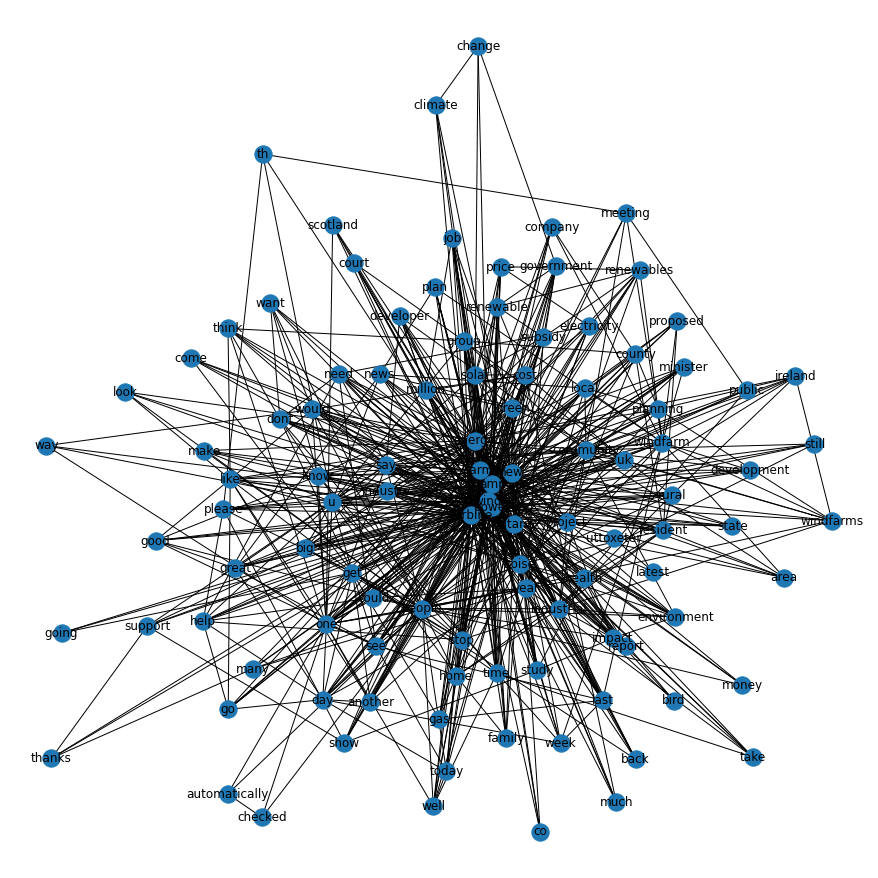

In [24]:
#less messy - still very messy
plt.figure(figsize=(12,12)) 

nx.draw(G_word_w, with_labels = True)

plt.show()

In [ ]:
#write to gephi for more playing around
nx.write_gexf(G_word_w, "weighted_word.gexf")

### Next step: filtering nodes(words) based on manual inspection

In [25]:
# prepare csv file for manual inspection
vocab_df = pd.DataFrame()
vocab_df['vocab'] = list(vocab_qualified)
vocab_df['accepted'] = 0            
vocab_df.to_csv('vocab.csv',index=False)

In [26]:
#load manually inspected vocabulary
vocab_df = pd.read_csv('vocab_new.csv',sep=';')

vocab_qualified = list(vocab_df[vocab_df['accepted'] == 1]['vocab'])

docs = [[w for w in doc if w in vocab_qualified] for doc in docs]

docs = [x for x in docs if x != []]

In [27]:
#edgelist with manually filtered vocabulary
manual_edge_list = []
for i in docs: # here you can proceed with the lemmatized version aswell
    sub = nx.complete_graph(i) # makes a fully connected graph out of oc-occurring words
    manual_edge_list.extend(list(sub.edges)) # add the edgelist from tweet to our edgelist for the whole collection of tweets

In [28]:
# Generate manually coded word graph with weights
manual_G = nx.Graph()

for edge in manual_edge_list:
    if edge in manual_G.edges(): 
        manual_G.edges[edge]['weight']+= 1
    else:
        manual_G.add_edge(edge[0],edge[1],weight=1) 

In [29]:
#print number of nodes and edges
manual_G.number_of_nodes(),manual_G.number_of_edges()

(55, 1047)

In [32]:
# Filter Edges based on weights
remove_edges = []
filter_edges = 3

for edge in manual_G.edges():
    if manual_G.edges[edge]['weight'] >= filter_edges:
        continue
    else:
        remove_edges.append(edge)

manual_G.remove_edges_from(remove_edges)

#remove nodes that are not at all connected to rest of network
manual_G.remove_nodes_from(list(nx.isolates(manual_G)))

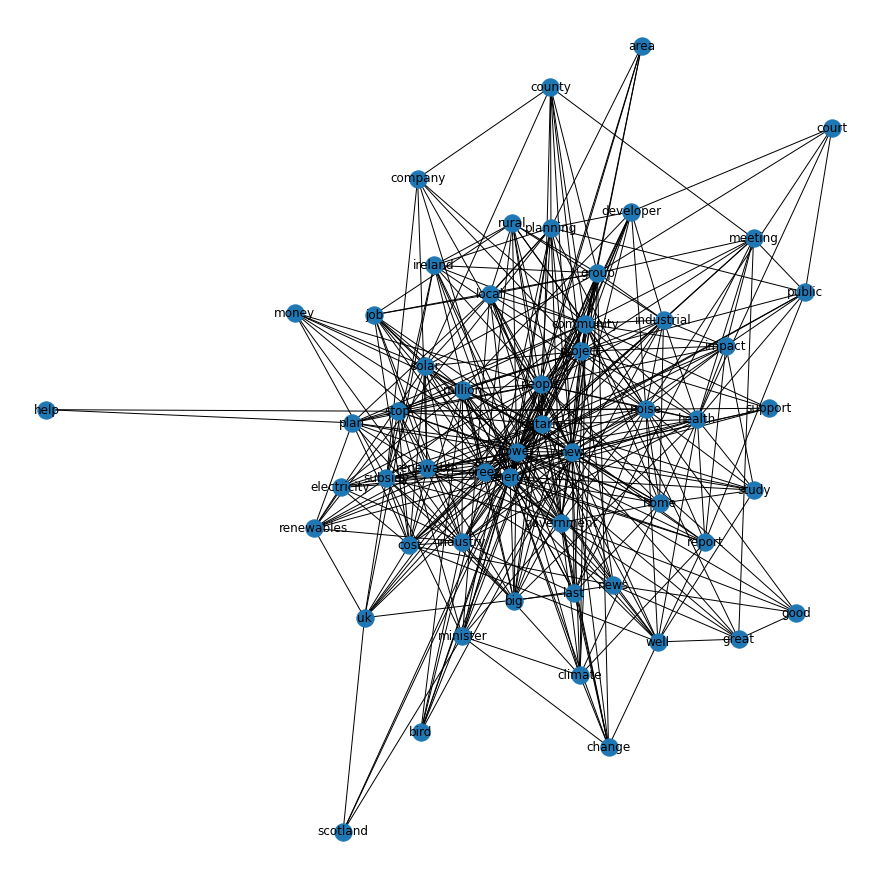

In [33]:
#plot graph
plt.figure(figsize=(12,12)) 

nx.draw(manual_G, with_labels = True)

plt.show()

In [ ]:
#write to gephi
nx.write_gexf(manual_G, "manual_g.gexf")

In [ ]:
#filter and make network only on words connected to actors
node = ['industry', 'government', 'community']

ind_edge = []

for item in manual_edge_list:
  if item[0] in node or item[1] in node:
    ind_edge.append(item)

In [ ]:
# Generate semantic network with weights centered on actors
industry_G = nx.Graph()

for edge in ind_edge:
    if edge in industry_G.edges(): 
        industry_G.edges[edge]['weight']+= 1
    else:
        industry_G.add_edge(edge[0],edge[1],weight=1) 

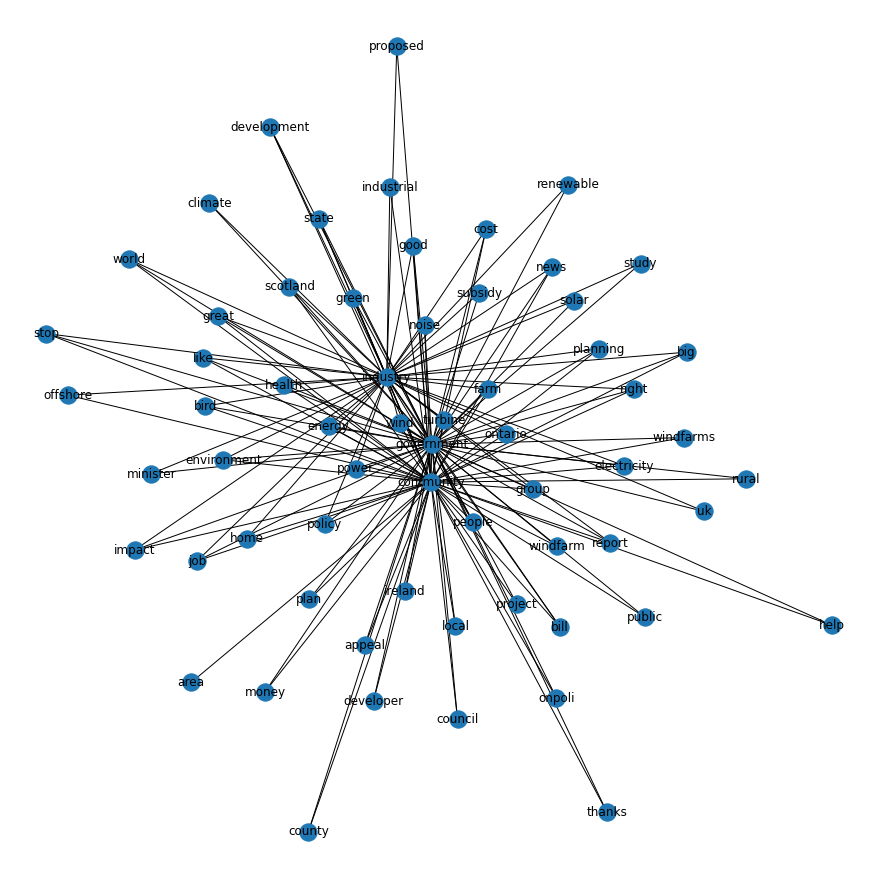

In [ ]:
plt.figure(figsize=(12,12)) 

nx.draw(industry_G, with_labels = True)

plt.show()

In [ ]:
#write to gephi
nx.write_gexf(industry_G, "actors.gexf")